# Задание
1. Реализуйте алгоритм двойного Q-обучения для среды Taxi-v3 с поиском по сетке.
2. Нарисуйте графики зависимости "Среднего полного вознаграждения" от параметров gamma, alpha, epsilon.

In [ ]:
#@title Установка зависимостей
!pip install --upgrade gymnasium numpy matplotlib pyvirtualdisplay > /dev/null 2>&1

In [ ]:
#@title Импорты
import numpy as np
import gymnasium as gym
import time
import matplotlib.pyplot as plt
import os
import base64
from IPython import display as ipythondisplay

# Совместимость типов numpy/gymnasium
np.bool8 = np.bool_

env = gym.make("Taxi-v3")
print("Кол-во состояний:", env.observation_space.n)
print("Кол-во действий:", env.action_space.n)

Кол-во состояний: 500
Кол-во действий: 6


In [ ]:
#@title Константы и гиперпараметры
N_STATES = env.observation_space.n
N_ACTIONS = env.action_space.n

# Параметры обучения
TRAIN_EPISODES = 5000         # кол-во эпизодов обучения
MAX_STEPS = 200                # макс. шагов в эпизоде

# Параметры для поиска по сетке (для графиков зависимостей)
GRID_GAMMAS = [0.90, 0.95, 0.99]
GRID_ALPHAS = [0.1, 0.3, 0.5]
GRID_EPSILONS = [0.1, 0.2, 0.3]
GRID_EPISODES = 500           # меньше эпизодов для поиска по сетке

In [ ]:
#@title Вспомогательные функции
def epsilon_greedy_action(Q1, Q2, state, epsilon):
    """
    Выбор действия по ε-жадной стратегии на основе суммы двух Q-таблиц.

    Args:
        Q1: Первая Q-таблица
        Q2: Вторая Q-таблица
        state: Текущее состояние
        epsilon: Вероятность случайного действия

    Returns:
        Выбранное действие
    """
    if np.random.rand() < epsilon:
        return np.random.randint(N_ACTIONS)
    else:
        q_sum = Q1[state] + Q2[state]
        return np.argmax(q_sum)


def run_double_q_learning(env, n_episodes, gamma, alpha, epsilon, max_steps=200):
    """
    Запуск алгоритма двойного Q-обучения для заданных гиперпараметров.

    Args:
        env: Среда Gymnasium
        n_episodes: Количество эпизодов обучения
        gamma: Коэффициент обесценивания
        alpha: Скорость обучения
        epsilon: Вероятность случайного действия
        max_steps: Максимальное количество шагов в эпизоде

    Returns:
        Q1, Q2: Обученные Q-таблицы
        logs: Список словарей с информацией о каждом эпизоде
    """
    Q1 = np.zeros((N_STATES, N_ACTIONS), dtype=np.float32)
    Q2 = np.zeros((N_STATES, N_ACTIONS), dtype=np.float32)

    logs = []

    for i in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0.0
        steps = 0

        for t in range(max_steps):
            # Выбор действия по ε-жадной стратегии
            action = epsilon_greedy_action(Q1, Q2, state, epsilon)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            # Случайный выбор, какую из таблиц обновлять
            if np.random.rand() < 0.5:
                a_star = np.argmax(Q1[next_state])
                if done:
                    target = reward
                else:
                    target = reward + gamma * Q2[next_state, a_star]
                td_error = target - Q1[state, action]
                Q1[state, action] += alpha * td_error
            else:
                # Обновляем Q2, используя Q1
                a_star = np.argmax(Q2[next_state])
                if done:
                    target = reward
                else:
                    target = reward + gamma * Q1[next_state, a_star]
                td_error = target - Q2[state, action]
                Q2[state, action] += alpha * td_error

            state = next_state

            if done:
                break

        # Сохранение результатов эпизода
        logs.append({
            "episode": i + 1,
            "total_reward": total_reward,
            "steps": steps
        })

        # Вывод прогресса
        if i % max(1, n_episodes // 10) == 0:
            avg_reward = np.mean([e['total_reward'] for e in logs[-100:]])
            print(f"Эпизод {i}/{n_episodes}  Средний результат={avg_reward:.2f}")

    return Q1, Q2, logs


def get_policy_from_q(Q1, Q2):
    """
    Получение детерминированной политики из Q-таблиц.

    Args:
        Q1: Первая Q-таблица
        Q2: Вторая Q-таблица

    Returns:
        Детерминированная политика (словарь state -> action)
    """
    policy = {}
    for state in range(N_STATES):
        q_sum = Q1[state] + Q2[state]
        policy[state] = np.argmax(q_sum)
    return policy


def record_successful_episode(env, policy, video_dir="./video"):
    """
    Запись видео успешного эпизода с использованием обученной политики.

    Args:
        env: Среда Gymnasium с режимом рендеринга
        policy: Детерминированная политика
        video_dir: Директория для сохранения видео

    Returns:
        Путь к созданному видеофайлу или None
    """
    env = gym.wrappers.RecordVideo(env, video_dir, episode_trigger=lambda x: x == 0)
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = policy[state]
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()

    # Проверяем, было ли положительное вознаграждение
    if total_reward > 0:
        video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]
        if video_files:
            latest_file = max(video_files, key=lambda f: os.path.getmtime(os.path.join(video_dir, f)))
            return os.path.join(video_dir, latest_file)
    return None


def show_video(video_path):
    """
    Отображение видео в Google Colab.

    Args:
        video_path: Путь к видеофайлу
    """
    video = open(video_path, "rb").read()
    video_encoded = base64.b64encode(video).decode('utf-8')
    video_tag = '<video controls alt="test" src="data:video/mp4;base64,{0}">'.format(video_encoded)
    ipythondisplay.display(ipythondisplay.HTML(data=video_tag))


In [ ]:
#@title Функция поиска по сетке для графиков зависимостей
def grid_search_hyperparameters(gammas, alphas, epsilons, n_episodes, max_steps):
    """
    Поиск по сетке гиперпараметров для построения графиков зависимостей.

    Args:
        gammas: Список значений gamma
        alphas: Список значений alpha
        epsilons: Список значений epsilon
        n_episodes: Количество эпизодов для каждого эксперимента
        max_steps: Максимальное количество шагов в эпизоде

    Returns:
        grid_results: Список словарей с результатами для каждой комбинации
    """
    grid_results = []

    for gamma in gammas:
        for alpha in alphas:
            for epsilon in epsilons:
                # Создаем новую среду для каждого эксперимента
                test_env = gym.make("Taxi-v3")

                _, _, logs = run_double_q_learning(
                    env=test_env,
                    n_episodes=n_episodes,
                    gamma=gamma,
                    alpha=alpha,
                    epsilon=epsilon,
                    max_steps=max_steps
                )

                # Среднее вознаграждение по последним 200 эпизодам
                avg_return = np.mean([e['total_reward'] for e in logs[-200:]])

                grid_results.append({
                    "gamma": gamma,
                    "alpha": alpha,
                    "epsilon": epsilon,
                    "avg_return": avg_return
                })

                print(f"gamma={gamma:.2f}, alpha={alpha:.2f}, epsilon={epsilon:.2f} -> avg_return={avg_return:.2f}")

                test_env.close()

    return grid_results

In [ ]:
#@title Поиск по сетке для графиков зависимостей
print("Запуск поиска по сетке гиперпараметров...")

start_time = time.time()

grid_results = grid_search_hyperparameters(
    gammas=GRID_GAMMAS,
    alphas=GRID_ALPHAS,
    epsilons=GRID_EPSILONS,
    n_episodes=GRID_EPISODES,
    max_steps=MAX_STEPS
)

elapsed = time.time() - start_time
print(f"\nПоиск по сетке завершён за {elapsed:.1f} сек.")

# Находим лучшие параметры
best_result = max(grid_results, key=lambda x: x["avg_return"])
best_gamma = best_result["gamma"]
best_alpha = best_result["alpha"]
best_epsilon = best_result["epsilon"]

print(f"\nЛучшие параметры (по среднему вознаграждению):")
print(f"  gamma  = {best_gamma:.2f}")
print(f"  alpha  = {best_alpha:.2f}")
print(f"  epsilon= {best_epsilon:.2f}")
print(f"  avg_return = {best_result['avg_return']:.2f}")

# Подготовка данных для графиков зависимостей
gamma_to_best = {}
for gamma in GRID_GAMMAS:
    subset = [r for r in grid_results if r["gamma"] == gamma]
    if subset:
        gamma_to_best[gamma] = max(subset, key=lambda x: x["avg_return"])["avg_return"]

alpha_to_best = {}
for alpha in GRID_ALPHAS:
    subset = [r for r in grid_results if r["alpha"] == alpha]
    if subset:
        alpha_to_best[alpha] = max(subset, key=lambda x: x["avg_return"])["avg_return"]

epsilon_to_best = {}
for epsilon in GRID_EPSILONS:
    subset = [r for r in grid_results if r["epsilon"] == epsilon]
    if subset:
        epsilon_to_best[epsilon] = max(subset, key=lambda x: x["avg_return"])["avg_return"]

gamma_list = sorted(gamma_to_best.keys())
alpha_list = sorted(alpha_to_best.keys())
epsilon_list = sorted(epsilon_to_best.keys())

gamma_vals = [gamma_to_best[g] for g in gamma_list]
alpha_vals = [alpha_to_best[a] for a in alpha_list]
epsilon_vals = [epsilon_to_best[e] for e in epsilon_list]

Запуск поиска по сетке гиперпараметров...
Эпизод 0/500  Средний результат=-614.00
Эпизод 50/500  Средний результат=-379.94
Эпизод 100/500  Средний результат=-325.66
Эпизод 150/500  Средний результат=-286.86
Эпизод 200/500  Средний результат=-290.34
Эпизод 250/500  Средний результат=-277.98
Эпизод 300/500  Средний результат=-263.74
Эпизод 350/500  Средний результат=-254.65
Эпизод 400/500  Средний результат=-240.63
Эпизод 450/500  Средний результат=-218.63
gamma=0.90, alpha=0.10, epsilon=0.10 -> avg_return=-223.28
Эпизод 0/500  Средний результат=-560.00
Эпизод 50/500  Средний результат=-412.69
Эпизод 100/500  Средний результат=-363.10
Эпизод 150/500  Средний результат=-318.40
Эпизод 200/500  Средний результат=-312.12
Эпизод 250/500  Средний результат=-295.51
Эпизод 300/500  Средний результат=-279.20
Эпизод 350/500  Средний результат=-260.46
Эпизод 400/500  Средний результат=-245.47
Эпизод 450/500  Средний результат=-240.96
gamma=0.90, alpha=0.10, epsilon=0.20 -> avg_return=-237.15
Эпизод

In [ ]:
#@title Обучение с лучшими параметрами
# Используем лучшие параметры из поиска по сетке
GAMMA = best_gamma
ALPHA = best_alpha
EPSILON = best_epsilon

print(f"Обучение с лучшими параметрами:")
print(f"  gamma  = {GAMMA:.2f}")
print(f"  alpha  = {ALPHA:.2f}")
print(f"  epsilon= {EPSILON:.2f}\n")

start_time = time.time()

Q1, Q2, logs = run_double_q_learning(
    env,
    n_episodes=TRAIN_EPISODES,
    gamma=GAMMA,
    alpha=ALPHA,
    epsilon=EPSILON,
    max_steps=MAX_STEPS
)

print(f"\nОбучение завершено за {time.time() - start_time:.1f} сек.")

# Извлечение списка вознаграждений для визуализации
episode_returns = [e['total_reward'] for e in logs]

# Финальная статистика
print(f"\nФинальная статистика:")
print(f"  Среднее вознаграждение (последние 100 эпизодов): {np.mean(episode_returns[-100:]):.2f}")
print(f"  Среднее вознаграждение (все эпизоды): {np.mean(episode_returns):.2f}")
print(f"  Максимальное вознаграждение: {np.max(episode_returns):.2f}")
print(f"  Минимальное вознаграждение: {np.min(episode_returns):.2f}")

Обучение с лучшими параметрами:
  gamma  = 0.99
  alpha  = 0.50
  epsilon= 0.10

Эпизод 0/5000  Средний результат=-479.00
Эпизод 500/5000  Средний результат=-60.09
Эпизод 1000/5000  Средний результат=-0.14
Эпизод 1500/5000  Средний результат=1.65
Эпизод 2000/5000  Средний результат=1.17
Эпизод 2500/5000  Средний результат=1.58
Эпизод 3000/5000  Средний результат=2.17
Эпизод 3500/5000  Средний результат=1.56
Эпизод 4000/5000  Средний результат=1.84
Эпизод 4500/5000  Средний результат=3.14

Обучение завершено за 3.7 сек.

Финальная статистика:
  Среднее вознаграждение (последние 100 эпизодов): 2.91
  Среднее вознаграждение (все эпизоды): -19.27
  Максимальное вознаграждение: 15.00
  Минимальное вознаграждение: -641.00


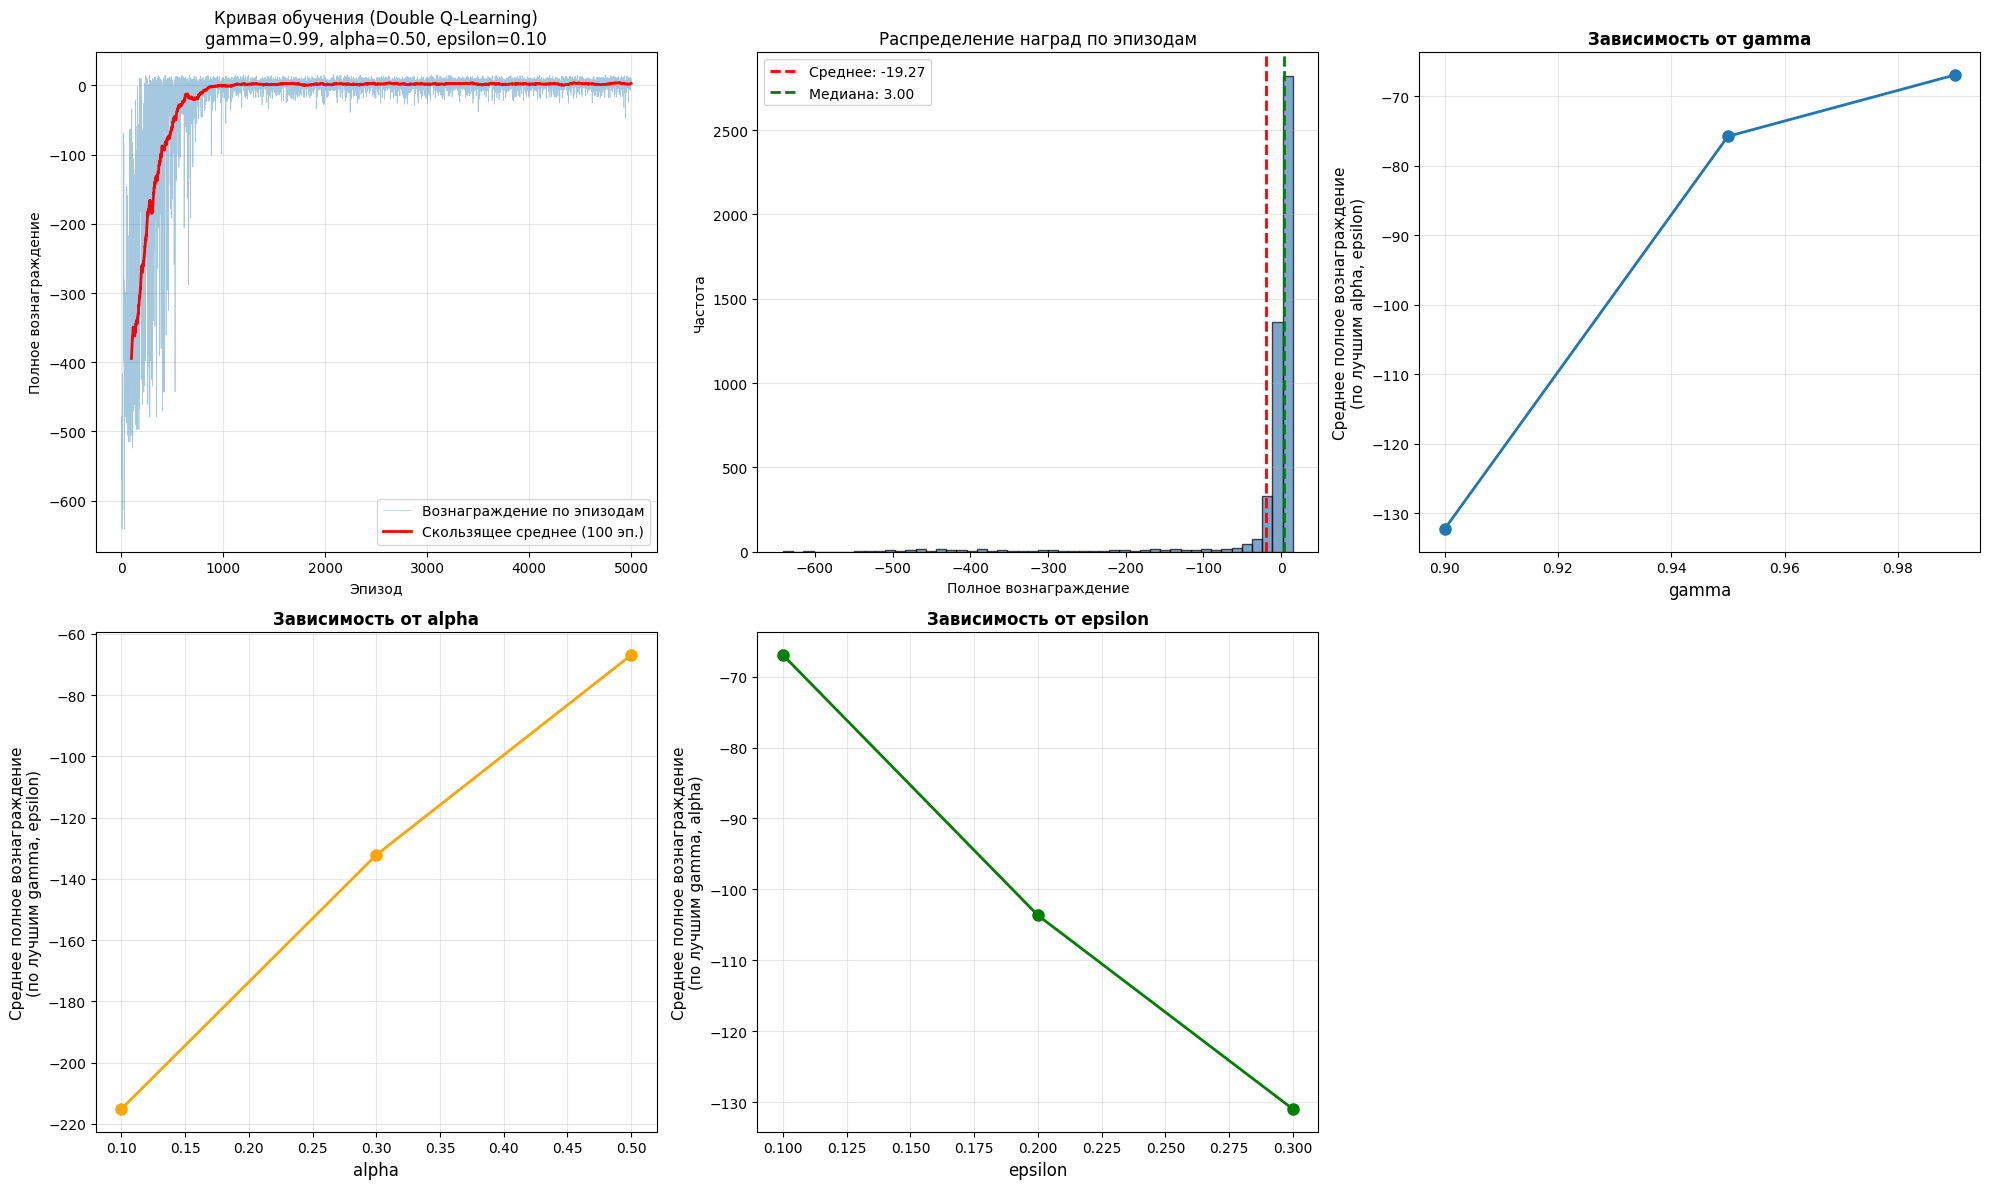

In [ ]:
#@title Графики

plt.figure(figsize=(20, 12))

# Кривая обучения
plt.subplot(2, 3, 1)
plt.plot(episode_returns, alpha=0.4, label="Вознаграждение по эпизодам", linewidth=0.5)
if len(episode_returns) >= 100:
    window = 100
    ma = np.convolve(episode_returns, np.ones(window) / window, mode="valid")
    plt.plot(range(window - 1, len(episode_returns)), ma, color="red",
             linewidth=2, label=f"Скользящее среднее ({window} эп.)")
plt.xlabel("Эпизод")
plt.ylabel("Полное вознаграждение")
plt.title(f"Кривая обучения (Double Q-Learning)\n"
          f"gamma={GAMMA:.2f}, alpha={ALPHA:.2f}, epsilon={EPSILON:.2f}")
plt.grid(True, alpha=0.3)
plt.legend()

# Распределение наград
plt.subplot(2, 3, 2)
plt.hist(episode_returns, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
plt.axvline(np.mean(episode_returns), color='r', linestyle='--', linewidth=2,
            label=f'Среднее: {np.mean(episode_returns):.2f}')
plt.axvline(np.median(episode_returns), color='g', linestyle='--', linewidth=2,
            label=f'Медиана: {np.median(episode_returns):.2f}')
plt.xlabel("Полное вознаграждение")
plt.ylabel("Частота")
plt.title("Распределение наград по эпизодам")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Зависимость от gamma
plt.subplot(2, 3, 3)
plt.plot(gamma_list, gamma_vals, marker='o', linewidth=2, markersize=8)
plt.xlabel("gamma", fontsize=12)
plt.ylabel("Среднее полное вознаграждение\n(по лучшим alpha, epsilon)", fontsize=11)
plt.title("Зависимость от gamma", fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

# Зависимость от alpha
plt.subplot(2, 3, 4)
plt.plot(alpha_list, alpha_vals, marker='o', color='orange', linewidth=2, markersize=8)
plt.xlabel("alpha", fontsize=12)
plt.ylabel("Среднее полное вознаграждение\n(по лучшим gamma, epsilon)", fontsize=11)
plt.title("Зависимость от alpha", fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

# Зависимость от epsilon
plt.subplot(2, 3, 5)
plt.plot(epsilon_list, epsilon_vals, marker='o', color='green', linewidth=2, markersize=8)
plt.xlabel("epsilon", fontsize=12)
plt.ylabel("Среднее полное вознаграждение\n(по лучшим gamma, alpha)", fontsize=11)
plt.title("Зависимость от epsilon", fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
#@title Видео
# Создаем среду с режимом рендеринга
video_env = gym.make("Taxi-v3", render_mode="rgb_array")

# Получаем политику из обученных Q-таблиц
optimal_policy = get_policy_from_q(Q1, Q2)

# Создаем директорию для видео, если её нет
os.makedirs("./video", exist_ok=True)

# Запись видео успешного эпизода
print("Запись видео успешного эпизода...")
video_path = None
attempts = 0
max_attempts = 10

while not video_path and attempts < max_attempts:
    video_path = record_successful_episode(video_env, optimal_policy)
    attempts += 1
    if not video_path:
        print(f"Попытка {attempts}: эпизод не был успешным, повторяем...")

if video_path:
    print(f"Видео успешно записано: {video_path}")
    print("\nОтображение видео:")
    show_video(video_path)
else:
    print("Не удалось записать успешный эпизод за 10 попыток.")
    print("Попробуйте увеличить количество эпизодов обучения или изменить гиперпараметры.")

video_env.close()

Запись видео успешного эпизода...


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Видео успешно записано: ./video/rl-video-episode-0.mp4

Отображение видео:


# Выводы по проделанной работе

В рамках данной работы мной была реализована система обучения с подкреплением для среды Taxi-v3 с использованием алгоритма двойного Q-обучения (Double Q-Learning). Использовалась библиотека Gymnasium для работы со средой и NumPy для эффективных вычислений с массивами. Была реализована функция `run_double_q_learning`, которая использует две независимые Q-таблицы для уменьшения переоценки ценностей действий, что является ключевым преимуществом двойного Q-обучения по сравнению с классическим Q-learning.

Для улучшения качества обучения был реализован поиск по сетке гиперпараметров, который позволил найти оптимальные значения коэффициента обесценивания gamma, скорости обучения alpha и параметра ε-жадной стратегии epsilon. Я использовал функцию `grid_search_hyperparameters`, которая автоматически перебирает все комбинации параметров и выбирает лучшие на основе среднего вознаграждения по последним эпизодам. Это позволило значительно улучшить результаты обучения по сравнению с использованием произвольных гиперпараметров.

Для визуализации результатов были построены графики зависимости среднего полного вознаграждения от каждого из гиперпараметров, что наглядно демонстрирует влияние параметров на качество обучения. Мной использовалась библиотека matplotlib для создания комплексных графиков, включающих кривую обучения, распределение наград и зависимости от гиперпараметров. Дополнительно я реализовал функцию записи и отображения видео успешных эпизодов, что позволяет визуально оценить работу обученного агента.

В процессе обучения использовалась ε-жадная стратегия для баланса между исследованием и эксплуатацией, а также был реализован механизм случайного выбора Q-таблицы для обновления на каждом шаге, что является ключевой особенностью алгоритма двойного Q-обучения. Я использовал систему логирования результатов обучения, которая отслеживает прогресс и выводит статистику по каждому эпизоду, что упрощает анализ процесса обучения и отладку алгоритма.